In [ ]:
!pip -q install transformers datasets accelerate torch scikit-learn gensim tashaphyne arabic-reshaper

import re
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer

import matplotlib.pyplot as plt

import nltk
from nltk.stem.isri import ISRIStemmer

from tashaphyne.stemming import ArabicLightStemmer

from gensim.models import FastText
from nltk.stem.snowball import SnowballStemmer

import torch
import torch.nn as nn



In [ ]:
df = pd.read_csv(r"/content/arabic_dataset_classifiction.csv")
df.head()

,text,targe
0,بين أستوديوهات ورزازات وصحراء مرزوكة وآثار ولي...,0
1,قررت النجمة الأمريكية أوبرا وينفري ألا يقتصر ع...,0
2,أخبارنا المغربية الوزاني تصوير الشملالي ألهب ا...,0
3,اخبارنا المغربية قال ابراهيم الراشدي محامي سعد...,0
4,تزال صناعة الجلود في المغرب تتبع الطريقة التقل...,0


In [ ]:
def normalize_arabic(text: str) -> str:
    text = re.sub(r"[إأآا]", "ا", text)
    text = re.sub(r"[ى]", "ي", text)
    text = re.sub(r"ة", "ه", text)
    text = re.sub(r"[\u0617-\u061A\u064B-\u0652]", "", text)
    text = re.sub(r"ـ", "", text)
    return text

def clean_regex(text: str) -> str:
    text = normalize_arabic(text)
    text = re.sub(r"http\S+|www\.\S+", " ", text)
    text = re.sub(r"@\w+|#\w+", " ", text)
    text = re.sub(r"[^\u0600-\u06FF\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text
df["text"] = df["text"].astype(str).apply(clean_regex)
df["text"] = df["text"].astype(str).apply(normalize_arabic)
df.head()

,text,targe
0,بين استوديوهات ورزازات وصحراء مرزوكه واثار ولي...,0
1,قررت النجمه الامريكيه اوبرا وينفري الا يقتصر ع...,0
2,اخبارنا المغربيه الوزاني تصوير الشملالي الهب ا...,0
3,اخبارنا المغربيه قال ابراهيم الراشدي محامي سعد...,0
4,تزال صناعه الجلود في المغرب تتبع الطريقه التقل...,0


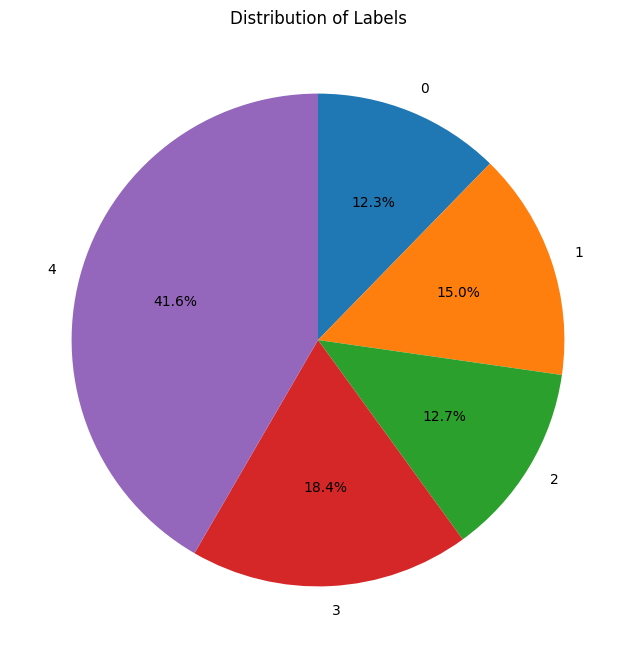

--------------------------------------------------
targe
0    13738
1    16728
2    14235
3    20505
4    46522
Name: count, dtype: int64


In [ ]:
import matplotlib.pyplot as plt

dist = df["targe"].value_counts().sort_index()

dist_percentage = dist / dist.sum() * 100

plt.figure(figsize=(8, 8))
dist_percentage.plot.pie(
    autopct="%1.1f%%",
    startangle=90,
    counterclock=False
)

plt.title("Distribution of Labels")
plt.ylabel("")
plt.show()

print("-" * 50)
print(dist)


In [ ]:
import numpy as np

rng = 42
min_size = df["targe"].value_counts().min()

df_down = (
    df.groupby("targe", group_keys=False)
      .apply(lambda x: x.sample(n=min_size, random_state=rng))
      .reset_index(drop=True)
)

df = df_down # Assign the downsampled dataframe back to df
df.shape

/tmp/ipython-input-1813901289.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=min_size, random_state=rng))


(68690, 2)

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [ ]:
import nltk
nltk.download('punkt')

isri = ISRIStemmer()
light = ArabicLightStemmer()
arabic_stemmer = SnowballStemmer("arabic")


def stem_text(text):
  if not isinstance(text, str):
    return ""
  tokens = nltk.word_tokenize(text)
  tokens = [isri.stem(t) for t in tokens]
  return " ".join(tokens)



def apply_snowball_stemmer(text):
  if not isinstance(text, str):
      return ""
  tokens = nltk.word_tokenize(text)
  tokens = [arabic_stemmer.stem(t) for t in tokens]
  return " ".join(tokens)


def apply_tashaphyne_stemmer(text):
  if not isinstance(text, str):
      return ""
  tokens = nltk.word_tokenize(text)
  stems = []
  for t in tokens:
      light.light_stem(t)
      stems.append(light.get_stem())
  return " ".join(stems)


df["text_isri"] = df["text"].astype(str).apply(stem_text)
df["text_light"] = df["text"].astype(str).apply(apply_tashaphyne_stemmer)
df["text_snowball"] = df["text"].astype(str).apply(apply_snowball_stemmer)

df.to_csv("stemming_data.csv", index=False)
df['text_isri'], df['text_light'], df['text_snowball']

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


(0        تحي فنن زهر هند حفل فنا يوم ارس قبل سرح تكل ار...
 1        بلغ عدد تفرج الذين حضر هرج لفر في دور ال ماب ش...
 2        خبر غرب تبع طلق شطء غرب حمل علي سبو ضمن مع خرج...
 3        اكد شرك في نده دول عقد بمد جدد حول وضع حصن ارخ...
 4        تدش فنن شعب غرب نجه عتبو بدء من ثلاثاء قبل جول...
                                ...                        
 68685    وضح قرر انجليزيه ان ندي مانشستر يتد يسع عقد مع...
 68686    عزم دير عمه ضرب حجز علي حسب صرف لجل ديه وطن مر...
 68687    كشف صدر علم غني ان تحد غني لكر قدم قلص من لئح ...
 68688    فرق حتج علي جمع سبب صبه ودي كرش اكد دره رجء ري...
 68689    كيف تقم ستي نخب غرب خلل وجه كونغو لم يكن نخب غ...
 Name: text_isri, Length: 68690, dtype: object,
 0        حي فنانه زهر هند حفل يا وم مارس مقبل مسرح اتاك...
 1        لغ عدد متفرج الذين حضر مهرج بولفار في دور ال م...
 2        خبار مغربيه متابع طلق شطاء مغارب حمل على فايسب...
 3        كد مشارك في دو دول انعقد مدين جديده حول موضوع ...
 4        دش فنانه شعبيه مغربيه جا عتابو بتداء من ثل

In [ ]:
df.head()

,text,targe,text_isri,text_light,text_snowball
0,تحيي الفنانه زهره هندي حفلا فنيا يوم مارس المق...,0,تحي فنن زهر هند حفل فنا يوم ارس قبل سرح تكل ار...,حي فنانه زهر هند حفل يا وم مارس مقبل مسرح اتاك...,تح فنانه زهر هند حفل فن يوم مارس مقبل مسرح اتا...
1,بلغ عدد المتفرجين الذين حضروا مهرجان البولفار ...,0,بلغ عدد تفرج الذين حضر هرج لفر في دور ال ماب ش...,لغ عدد متفرج الذين حضر مهرج بولفار في دور ال م...,بلغ عدد متفرج ذين حضرو مهرج بولفار في دور ال م...
2,اخبارنا المغربيه متابعه اطلق نشطاء مغاربه حمله...,0,خبر غرب تبع طلق شطء غرب حمل علي سبو ضمن مع خرج...,خبار مغربيه متابع طلق شطاء مغارب حمل على فايسب...,اخبار مغربيه متابع اطلق نشطاء مغارب حمل عل فاي...
3,اكد المشاركون في ندوه دوليه انعقدت بمدينه الجد...,0,اكد شرك في نده دول عقد بمد جدد حول وضع حصن ارخ...,كد مشارك في دو دول انعقد مدين جديده حول موضوع ...,اكد مشارك في ندو دول انعقد بمد جديده حول موضوع...
4,تدشن الفنانه الشعبيه المغربيه نجاه اعتابو ابتد...,0,تدش فنن شعب غرب نجه عتبو بدء من ثلاثاء قبل جول...,دش فنانه شعبيه مغربيه جا عتابو بتداء من ثلاثاء...,تدش فنانه شعبيه مغربيه نجا اعتاب ابتداء من ثلا...


In [67]:
df.to_csv("arabic_stemming.csv", index = False, encoding='utf-8-sig')